### Regression

In this notebook, an 'energy' regression model is explored

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import pandas as pd
import numpy as np
from data_prep import DataPrep

from data_loading import *

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from cross_validation import *

In [3]:
df=pd.read_csv('spotify.csv')

(9999, 35)

In [4]:
dp = DataPrep(df)

In [5]:
columns_to_drop=['Artist URI(s)', 'Album URI', 'Album Artist URI(s)',
                 'Album Image URL', 'Disc Number', 'Track Preview URL', 'ISRC',
                 'Added By', 'Added At', 'Copyrights', 'Album Genres']

cat_columns = ['Artist Name(s)','Label','Decade','Key']

dp.prepare_data(drop_columns=columns_to_drop,   #columns to remove
                cat_columns=cat_columns,        #categorical columns i.e mapping to integer
                text_columns=['Track Name','Album Name'], #columns to encode using sent2vec
                n_components_text=2)            #number of features to reduce text columns down to

Using PCA
Using PCA


### get ten train test splits

In [6]:
variable = 'Energy'

data = dp.df

float_columns = ['Popularity','Track Duration (ms)', 'Explicit', 'Danceability', 'Energy', 'Key', 'Loudness',
                 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness','Valence', 'Tempo', 'Time Signature']

train_test_splits = create_train_test_splits(data, stratified=False,
                                             dependent_column=variable,
                                             n_splits=10,
                                             test_size=0.20)

#### get list of architectures
then train cross validation stype

In [7]:
architectures = [XGBRegressor,DecisionTreeRegressor,LinearRegression,ElasticNet,AdaBoostRegressor]
normalise     = [True, False]

In [12]:
reports = []
for arch in tqdm(architectures):
    for norm in normalise:
        reports.append(perform_cross_validation(dataset=data,
                                                architecture=arch,
                                                splits=train_test_splits,
                                                dependent_column=variable,
                                                normalise=norm,
                                                mode='regression'))
reg_results = pd.DataFrame(reports)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.88s/it]


In [13]:
reg_results

,arch,normalise,num_features,rmse mean,rmse std,r2 mean,r2 std,residual
0,XGBRegressor,True,70,0.093618,0.001707,0.758986,1.020483e-02,"[0.15038383, -0.012882054, 0.027650058, -0.002..."
1,XGBRegressor,False,70,0.093549,0.001676,0.759339,1.019072e-02,"[0.15038383, -0.012882054, 0.027650058, -0.002..."
2,DecisionTreeRegressor,True,70,0.136070,0.001421,0.490894,1.760083e-02,"[-0.06700003147125244, -0.14100003242492676, -..."
3,DecisionTreeRegressor,False,70,0.135667,0.001795,0.493850,1.988400e-02,"[-0.06700003147125244, -0.1420000195503235, -0..."
4,LinearRegression,True,70,60.641991,181.613297,-989223.686875,2.967673e+06,"[0.2831453, -0.05713302, -0.01495719, 0.009263..."
5,LinearRegression,False,70,0.109436,0.006732,0.669565,4.272554e-02,"[0.2621106, -0.09640992, -0.050473213, -0.0316..."
6,ElasticNet,True,70,0.190837,0.002356,-0.000783,7.351451e-04,"[0.18895304, 0.026953042, -0.12004691, -0.0590..."
7,ElasticNet,False,70,0.185620,0.002277,0.053162,6.817872e-03,"[0.21623838, 0.07039988, -0.11696762, -0.10455..."
8,AdaBoostRegressor,True,70,0.116189,0.001874,0.628890,1.145302e-02,"[0.21730561556186467, 0.050185106925451195, -0..."
9,AdaBoostRegressor,False,70,0.115902,0.001349,0.630683,1.111104e-02,"[0.21395273603146936, 0.04815835181797179, -0...."


### make table of results

In [11]:
results_copy = reg_results.copy()
results_copy = results_copy.sort_values(by='rmse mean',ascending=False)
results_copy = results_copy[['arch','normalise','rmse mean', 'rmse std', 'r2 mean', 'r2 std']]
results_copy['rmse'] = [f'{i:.3f} ± {j:.3f}' for i,j in results_copy[['rmse mean','rmse std']].values]
results_copy['r2'] = [f'{i:.3f} ± {j:.3f}' for i,j in results_copy[['r2 mean','r2 std']].values]
results_copy.drop(columns=['rmse mean', 'rmse std', 'r2 mean', 'r2 std']).reset_index(drop=True).head()

NameError: name 'reg_results' is not defined

### quickly test a model

In [12]:
m = XGBRegressor()
(train_x,train_y),(test_x,test_y) = get_train_and_test_set(data,split=train_test_splits[0],
                                                           dependent_column='Energy')

m.fit(train_x,train_y)
m.feature_importances_
mean_squared_error(test_y,m.predict(test_x),squared=False)

0.092379354

In [14]:
pred = m.predict(test_x)

### make a residual plot

Text(0.5, 0, '$|y_{true}-y_{pred}|$')

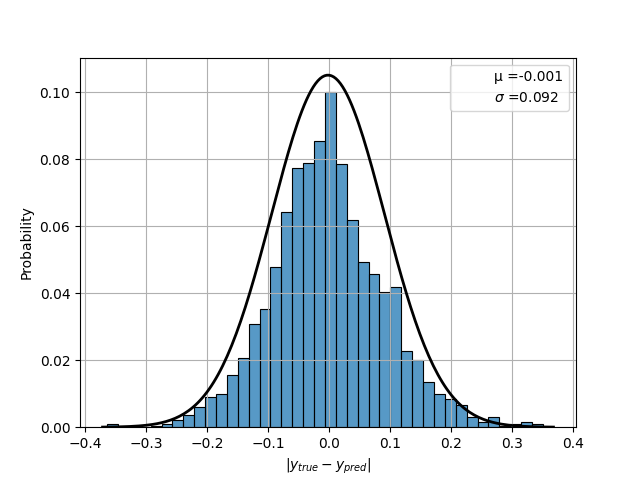

In [57]:
from scipy import stats
def normal(mean, std, histmax=False, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    if histmax:
        p = p*histmax/max(p)
    z = plt.plot(x, p, color, linewidth=2)

fig,ax = plt.subplots()
data = pred - test_y  
ax = sns.histplot(x=data, stat="probability")
normal(data.mean(), data.std(), histmax=ax.get_ylim()[1])
ax.grid()
ax.plot([], [], ' ', label=f"µ ={data.mean():.3f}")
ax.plot([], [], ' ', label=f"$\sigma$ ={data.std():.3f}")
ax.legend()
ax.set_xlabel('$|y_{true}-y_{pred}|$')

### feature importance

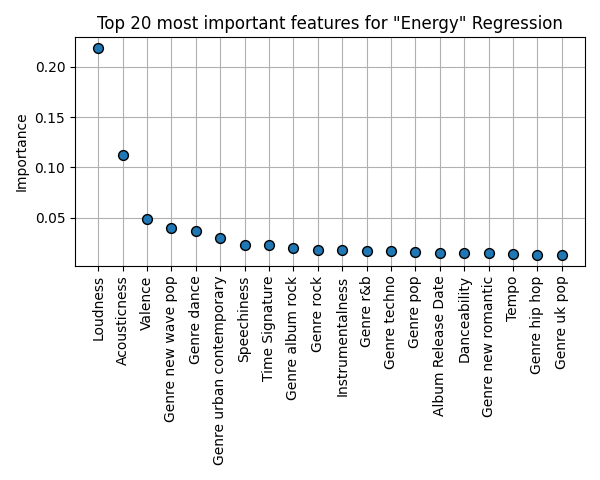

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(6,4.8))
names  = [i for i in data.columns if i not in [variable,'Track URI']]
imp    = m.feature_importances_
asort  = imp.argsort()[::-1]
imp    = imp[asort][:20]
names  = np.array(names)[asort][:20]
ax.scatter(np.arange(1,len(imp)+1),imp,zorder=10,edgecolor='k',s=50)
ax.set_xticks(np.arange(1,len(imp)+1))
ax.set_xticklabels(names,rotation=90)
ax.set_ylabel('Importance')
ax.set_title('Top 20 most important features for "Energy" Regression')
ax.grid(zorder=-1)
fig.tight_layout()
fig.set_dpi(150)